#  <u>Classificação de Imagens com Inteligência Artificial</u>

## Trabalho de Conclusão de Curso apresentado ao Curso de Especialização em Inteligência Artificial e Aprendizado de Máquina, como requisito parcial à obtenção do título de Especialista

### Autor: Marcos Francisco Ribeiro Ferreira marcosfrf@gmail.com
___

### Instalar pacotes

In [ ]:
!pip install sklearn
!pip install scikit-image
!pip install pandas
!pip install seaborn
!pip install sklearn-evaluation
!pip install scikeras
!pip install opencv-python
#!pip install --upgrade tensorflow

### Importar dependências

In [46]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from skimage.io import imread
import pandas as pd
import warnings
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import model_selection
import time
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import History
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import datasets
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from joblib import dump, load

### Configurar o ambiente

In [47]:
BASE_DIR = os.path.join('/Users/marco/Documents/DS/puc-projeto')

DATA_DIR = os.path.join(BASE_DIR, 'dados')

MODEL_DIR = os.path.join(BASE_DIR, 'modelos')

class_names = os.listdir(DATA_DIR)

SEED=42
KNN="knn"
RANDOM_FOREST="rf"
SVM="svm"
CNN="cnn"
IMG_SIZE=48
CV=2          # controla o número de divisões k-fold no cross validation
TRAIN_SIZE=0.8
REPLACE=False # controla se os modelos devem ser novamente gerados mesmo existindo no disco

### Ler a base de imagens

In [48]:
imagens = []
labels = []
def load_images(dir, imagens, labels):
    for category in class_names:
        path=os.path.join(dir, category)
        class_num=class_names.index(category)
        for img in os.listdir(path):
            try:
                image=cv2.imread(os.path.join(path,img))
                image=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
                
                imagens.append(image)
                labels.append(class_num)
            except Exception as e:
                pass

load_images(DATA_DIR, imagens, labels)  

print(f"Total de imagens: {len(imagens)}")

Total de imagens: 6899


### Visualizar amostras de imagens

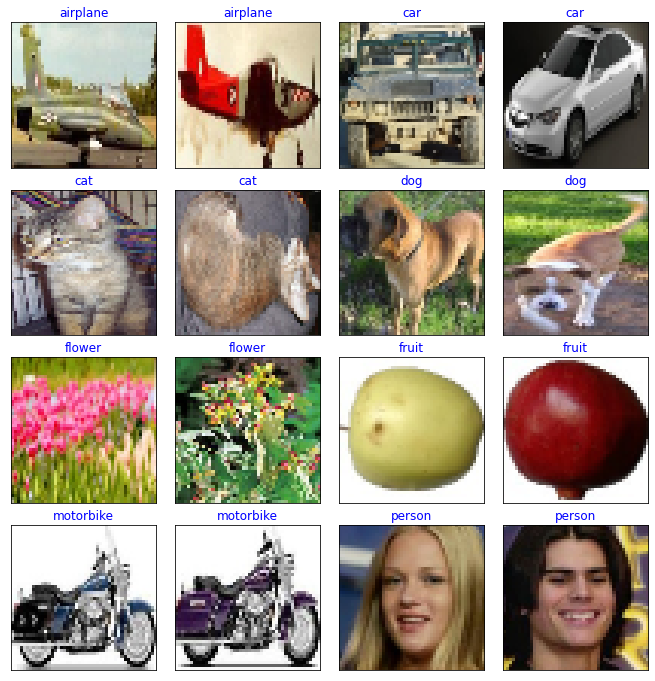

In [49]:
fig = plt.figure(figsize=(9, 9))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.05)
col = 0 
for category in class_names:
    count = 0
    path=os.path.join(DATA_DIR, category)
    class_num=class_names.index(category)
    for img in os.listdir(path):
        if count > 1:
            break
        image=cv2.imread(os.path.join(path,img))
        image=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        ax = fig.add_subplot(4, 4, col + 1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.rc('axes', titlesize=12)
        title = plt.title(str(category))
        plt.setp(title, color="b")         
        col += 1 
        count += 1     

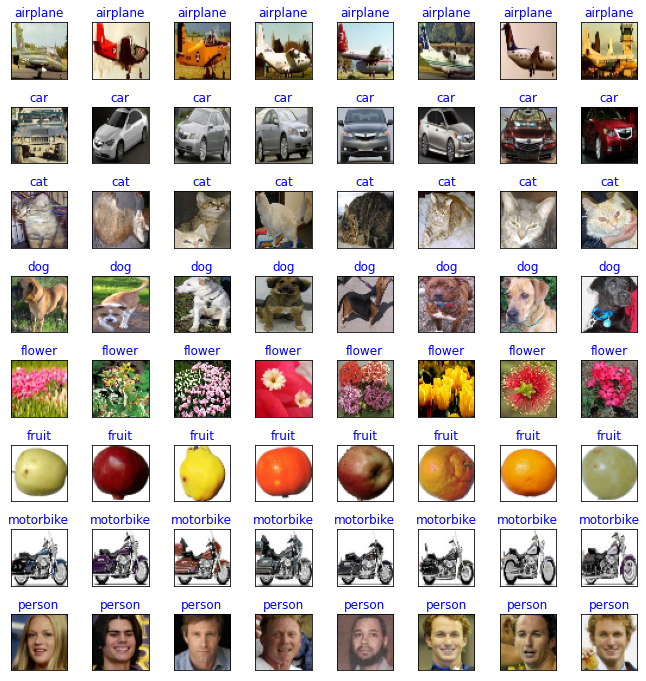

In [50]:
fig = plt.figure(figsize=(9, 9))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
col = 0 
for category in class_names:
    count = 0
    path=os.path.join(DATA_DIR, category)
    class_num=class_names.index(category)
    for img in os.listdir(path):
        if count > 7:
            break
        image=cv2.imread(os.path.join(path,img))
        image=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        ax = fig.add_subplot(8, 8, col + 1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.rc('axes', titlesize=12)
        title = plt.title(str(category))
        plt.setp(title, color="b")         
        col += 1 
        count += 1  

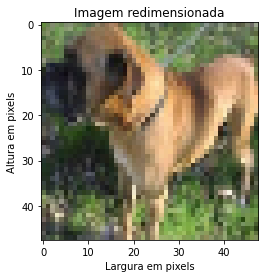

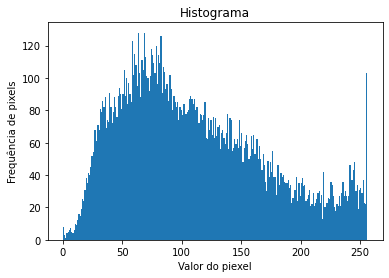

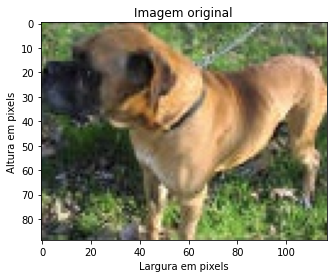

In [51]:
path=os.path.join(DATA_DIR, 'dog')
for img in os.listdir(path):
    img
    break

image = cv2.imread(os.path.join(path,img))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_canal0=image[:,:,0] #r
image_canal1=image[:,:,1] #g
image_canal2=image[:,:,2] #b


'''color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()'''

'''plt.hist(image.ravel(),256,[0,256])
plt.show()'''


plt.xlabel("Largura em pixels")
plt.ylabel("Altura em pixels")
plt.title("Imagem redimensionada")
plt.imshow(cv2.resize(image,(IMG_SIZE,IMG_SIZE)))  
plt.show()

plt.title("Histograma")
plt.xlabel("Valor do piexel")
plt.ylabel("Frequência de pixels")
plt.hist(image_canal0.ravel(),256,[0,256], color='tab:blue')
plt.hist(image_canal1.ravel(),256,[0,256], color='tab:blue')
plt.hist(image_canal2.ravel(),256,[0,256], color='tab:blue')
plt.show()

plt.xlabel("Largura em pixels")
plt.ylabel("Altura em pixels")
plt.title("Imagem original")
plt.imshow(image)   
plt.show()

### Normalizar os dados de imagens

In [52]:
imagens = np.array(imagens, dtype="float")/255.0
imagens.shape

(6899, 48, 48, 3)

### Separar as bases de treinamento e teste

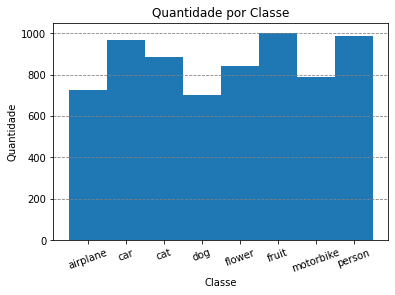

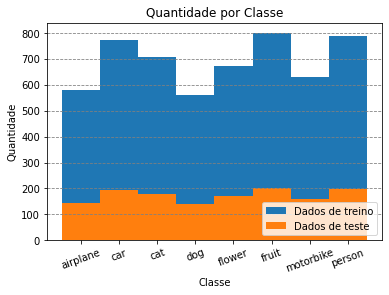

In [53]:
(classes, totais) = np.unique(labels, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(classes, labels=class_names,rotation=20)
plt.bar(classes, totais, 1)
plt.title('Quantidade por Classe')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.show()

(X_train, X_test, y_train, y_test) = model_selection.train_test_split(imagens, 
                                                                      labels, 
                                                                      train_size=TRAIN_SIZE, 
                                                                      random_state=SEED, 
                                                                      stratify=labels)

(classes, totais_train) = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(classes, labels=class_names,rotation=20)
plt.bar(classes, totais_train, 1, label="Dados de treino")
plt.title('Quantidade por Classe')
plt.xlabel('Classe')
plt.ylabel('Frequência')

(classes, totais_test) = np.unique(y_test, return_counts=True)

plt.bar(classes, totais_test, 1, label="Dados de teste")
plt.title('Quantidade por Classe')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.legend(loc='lower right')
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.show()

#print(f"Percentual de treino: {TRAIN_SIZE}. Totais de imagens. Treinamento: {len(X_train)}. Teste: {len(X_test)}")

<AxesSubplot:>

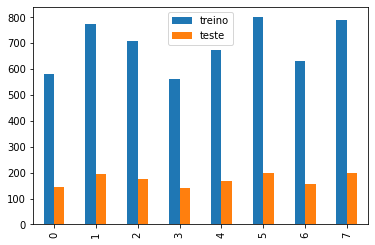

In [54]:
x = {'geral': totais, 'treino': totais_train, 'teste':totais_test}

df = pd.DataFrame(data=x, index=classes)

df['percentual_treino'] = (df['treino']/df['geral'])*100
df['percentual_teste'] = (df['teste']/df['geral'])*100

df[['treino','teste']].plot.bar()

### Preparar dados nos formatos matriz 2D e 4D e rotulos nos formatos lista e matriz 2D 
#### cnn: dados matriz 4D e rotulos matriz 2D
#### demais modelos: dados matriz 2D e rotulos lista

In [55]:
# Dados e rótulos para o modelo CNN
X_train_cnn = np.copy(X_train)
X_test_cnn = np.copy(X_test)
y_train_cnn = np.array(y_train).reshape(len(y_train),1)
y_test_cnn = np.array(y_test).reshape(len(y_test),1)

# Dados e rótulos para os demais modelos
X_train = np.array(X_train).reshape(len(X_train),-1)
X_test = np.array(X_test).reshape(len(X_test),-1)
y_train = y_train
y_test = y_test

print(f"X_train_cnn {X_train_cnn.shape}")
print(f"y_train_cnn {y_train_cnn.shape}")
print(f"X_test_cnn {X_test_cnn.shape}")
print(f"y_test_cnn {y_test_cnn.shape}")

print(f"X_train {X_train.shape}")
print(f"y_train {type(y_train)}, {len(y_train)}")
print(f"X_test {X_test.shape}")
print(f"y_test {type(y_test)}, {len(y_test)}")

X_train_cnn (5519, 48, 48, 3)
y_train_cnn (5519, 1)
X_test_cnn (1380, 48, 48, 3)
y_test_cnn (1380, 1)
X_train (5519, 6912)
y_train <class 'list'>, 5519
X_test (1380, 6912)
y_test <class 'list'>, 1380


### Persistir modelo

In [56]:
def salvar_modelo(model_name, model, grid):
    file_name = model_name + '_cv_' + str(CV) + '_img_size_' + str(IMG_SIZE)

    print(f"Salvando o modelo {model_name} em {MODEL_DIR}")
    dump(model, os.path.join(MODEL_DIR, file_name + '.joblib'))
    dump(grid, os.path.join(MODEL_DIR, file_name + '_grid.joblib'))
    print("pronto!")
    
def carregar_modelo(model_name):    
    file_name = model_name + '_cv_' + str(CV) + '_img_size_' + str(IMG_SIZE)

    if not REPLACE and os.path.isfile(os.path.join(MODEL_DIR, file_name + '.joblib')):
        print(f"Carregando o modelo {model_name}: ({file_name})")
        model = load(os.path.join(MODEL_DIR, file_name + '.joblib'))
        grid = load(os.path.join(MODEL_DIR, file_name + '_grid.joblib'))
        print("pronto!")
            
        return [model, grid]
    else:
        print(f"Modelo {model_name} ({file_name}) não encontrado ou ignorado (REPLACE={REPLACE}).")
        return None, None
    
def salvar_modelo_cnn(model_name, model, history, grid):
    file_name = model_name + '_cv_' + str(CV) + '_img_size_' + str(IMG_SIZE)

    print(f"Salvando o modelo {model_name}...")
    model.save(os.path.join(MODEL_DIR, file_name + '.h5'))
    np.save(os.path.join(MODEL_DIR, file_name + '_history.npy'), history.history)    
    dump(grid, os.path.join(MODEL_DIR, file_name + '_grid.joblib'))
    print("pronto!")
    
def carregar_modelo_cnn(model_name):    
    file_name = model_name + '_cv_' + str(CV) + '_img_size_' + str(IMG_SIZE)
    
    if not REPLACE and os.path.isfile(os.path.join(MODEL_DIR, file_name + '.h5')):
        print(f"Carregando o modelo {model_name}: ({file_name})")
        model = keras.models.load_model(os.path.join(MODEL_DIR, file_name + '.h5'))
        history = np.load(os.path.join(MODEL_DIR, file_name + '_history.npy'), allow_pickle='TRUE').item()
        grid = load(os.path.join(MODEL_DIR, file_name + '_grid.joblib'))
        print("pronto!")
        return [model, history, grid]
    else:
        print(f"Modelo {model_name} ({file_name}) não encontrado ou ignorado (REPLACE={REPLACE}).")
        return None, None, None

### Visualizar predições do modelo

In [57]:
def visualizar_predicoes(model):
    test_class = None

    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    count = 1
    correto = 0
    for i,img in enumerate(X_test):
        if test_class and class_names[y_test[i]] != test_class:
            continue

        if count > 64:
            break

        # predict label of test image (reshape do formato da imagem de acordo com o modelo: CNN e demais
        if isinstance(model, models.Sequential):
            img_x = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
            
            prediction = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))
            prediction_value = np.argmax(prediction)
        else:    
            img_x = img.reshape(1,-1)
            prediction = model.predict(img.reshape(1,-1))[0]
            prediction_value = prediction
         
        # show predicted label on image
        if test_class and class_names[prediction_value] == test_class or prediction_value == y_test[i]:
            cor = 'b'
            correto += 1
        else:
            cor = 'r'

        # refazendo formato RGB da imagem    
        img = img.reshape(IMG_SIZE, IMG_SIZE, 3)    
        img = img * 255
        img = img.astype('uint8')

        fig.add_subplot(8, 8, count, xticks=[], yticks=[])
        #plt.subplots_adjust(left=0, bottom=0, right=None, top=None, wspace=0, hspace=0)

        plt.axis('off')
        title = plt.title(class_names[prediction_value])
        plt.setp(title, color=cor) 
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.rc('axes', titlesize=12)

        count+=1
        

    print(f'Acurácia: {((correto / (count - 1)) * 100):.2f} ({correto} de {(count-1)})')
    
    plt.show()

### Visualizar a Matriz Confusão

In [58]:
def visualizar_matriz_confusao(cm, y_test, y_pred, exibir_percentual_fora_diagonal):
    df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                      columns = [i for i in class_names])

    cm_sum = np.sum(cm, axis=0, keepdims=True)
    cm_sum = cm_sum.reshape(-1,1)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)

    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d\n%.1f%%' % (c, s, p)
            else:
                if exibir_percentual_fora_diagonal:
                    annot[i, j] = '%d\n%.1f%%' % (c, p)
                else:    
                    annot[i, j] = '%d' % (c)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm/np.sum(df_cm), annot=annot, 
                fmt='', cmap='Blues')

### Visualizar scores de treinamento

In [59]:
def visualizar_scores_parametros(parametros, ylabel, xlabel, xlabel_rotation=0):
    fig = plt.figure(figsize = (10,7))
    ax = fig.add_subplot(1, 1, 1)
    
    for parametro in parametros:
        ax.plot(parametro['x'], parametro['y'], label=parametro['label'])
        
    ax.set_xticks(parametro['x'])
    ax.tick_params(axis='x', labelrotation=xlabel_rotation)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.legend()

### Visualizar resultados GridSearchCV

In [60]:
def visualizar_resultado_gridsearchcv(grid):
    print("Melhor acurácia média: %f com os parâmetros %s" % (grid.best_score_, grid.best_params_))
    acuracia_media = grid.cv_results_['mean_test_score']
    tempo_medio = grid.cv_results_['mean_score_time']
    desvio_padrao = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    for mean, stdev, time, param in zip(acuracia_media, desvio_padrao, tempo_medio, params):
        print("Acurácia média: %f desvio padrão: (%f) tempo médio de score: {%f) segs. Parâmetros: %r" % (mean, stdev, time, param))

### Criar o DataFrame do classification_report para consolidação de dados

In [61]:
def criar_classification_report_df(classificador, y_test, y_pred):
    df = pd.DataFrame(classification_report(y_test, y_pred, target_names=class_names, output_dict=True)).transpose()
    df['classificador'] = classificador
    
    return df     

def concatenar_classification_report_df(df_lista):
    df = pd.concat(df_lista)

    df['variavel'] = df.index
    df.reset_index(drop=True, inplace=True)

    return df    

## Classificador KNN
___

### Carregar ou treinar o modelo

In [62]:
knn, grid_knn = carregar_modelo(KNN)

if not knn:
    start_time = time.time()
    print(f"Encontrando os melhores valores para os hiper parâmetros...")
    parameters = {'n_neighbors':list(range(5,22,2)),
                  'p': [1,2]}    
    knn = KNeighborsClassifier()
    grid_knn = GridSearchCV(knn, parameters, cv=CV, scoring='accuracy', 
                        return_train_score=False, verbose=3, refit=True)
    grid_knn.fit(X_train, y_train)
    
    print(f"Melhor score médio: {grid_knn.best_score_}")
    print(f"Melhores parametros: {grid_knn.best_params_}")
    
    print(f"Salvando modelo KNN treinado com os melhores parâmetros encontrados.")
    knn = grid_knn.best_estimator_
    
    salvar_modelo(KNN, knn, grid_knn)   
    print(f"Treinamento finalizado em {time.time() - start_time} segundos.")
    
knn    

Carregando o modelo knn: (knn_cv_2_img_size_48)
pronto!


KNeighborsClassifier(n_neighbors=9, p=1)

### Visualizar a acurácia por parâmetros

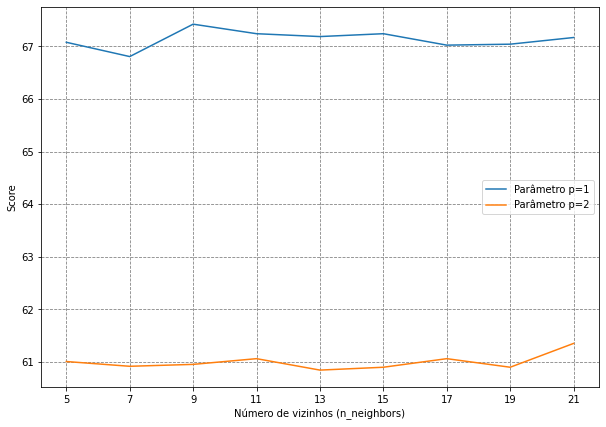

In [63]:
df_result = pd.DataFrame(grid_knn.cv_results_)[['param_n_neighbors','param_p','mean_test_score']].astype('float64')
df_result_p1 = df_result.loc[df_result['param_p'] == 1]
df_result_p2 = df_result.loc[df_result['param_p'] == 2]
    
visualizar_scores_parametros([{'x':df_result_p1['param_n_neighbors'],'y':df_result_p1['mean_test_score']*100,'label':'Parâmetro p=1'},
                              {'x':df_result_p1['param_n_neighbors'],'y':df_result_p2['mean_test_score']*100,'label':'Parâmetro p=2'}
                             ], "Score", "Número de vizinhos (n_neighbors)")    

### Visualizar resultados do treinamento com GridSearchCV

In [64]:
visualizar_resultado_gridsearchcv(grid_knn)

Melhor acurácia média: 0.674219 com os parâmetros {'n_neighbors': 9, 'p': 1}
Acurácia média: 0.670775 desvio padrão: (0.009906) tempo médio de score: {46.053675) segs. Parâmetros: {'n_neighbors': 5, 'p': 1}
Acurácia média: 0.610076 desvio padrão: (0.008627) tempo médio de score: {0.981962) segs. Parâmetros: {'n_neighbors': 5, 'p': 2}
Acurácia média: 0.668058 desvio padrão: (0.010087) tempo médio de score: {45.224574) segs. Parâmetros: {'n_neighbors': 7, 'p': 1}
Acurácia média: 0.609170 desvio padrão: (0.009895) tempo médio de score: {0.926514) segs. Parâmetros: {'n_neighbors': 7, 'p': 2}
Acurácia média: 0.674219 desvio padrão: (0.012262) tempo médio de score: {46.390437) segs. Parâmetros: {'n_neighbors': 9, 'p': 1}
Acurácia média: 0.609533 desvio padrão: (0.013156) tempo médio de score: {0.958436) segs. Parâmetros: {'n_neighbors': 9, 'p': 2}
Acurácia média: 0.672406 desvio padrão: (0.007551) tempo médio de score: {45.619884) segs. Parâmetros: {'n_neighbors': 11, 'p': 1}
Acurácia média:

### Medir a acuracia do modelo

In [65]:
print(f"Acuracia do modelo nos dados de teste: {knn.score(X_test, y_test)}")

Acuracia do modelo nos dados de teste: 0.6934782608695652


### Matriz confusão e Relatório de classificação

              precision    recall  f1-score   support

    airplane       0.61      0.96      0.74       145
         car       0.88      0.66      0.76       194
         cat       0.39      0.83      0.53       177
         dog       0.48      0.10      0.17       140
      flower       0.93      0.32      0.48       169
       fruit       0.91      1.00      0.95       200
   motorbike       1.00      0.58      0.73       158
      person       0.81      0.93      0.86       197

    accuracy                           0.69      1380
   macro avg       0.75      0.67      0.65      1380
weighted avg       0.76      0.69      0.67      1380



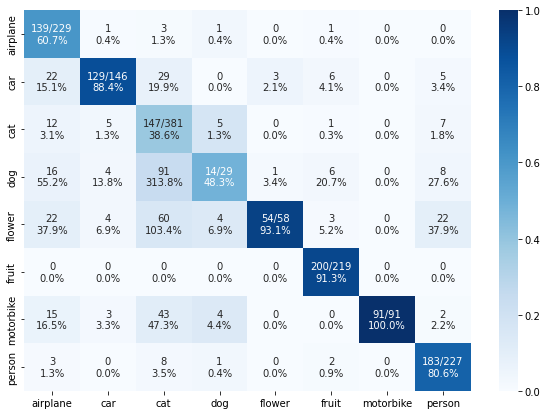

In [66]:
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

visualizar_matriz_confusao(cm, y_test, y_pred, True)

print(classification_report(y_test, y_pred, target_names=class_names))

df_class_report_knn = criar_classification_report_df(KNN, y_test, y_pred)

 ### Visualizar predições

Acurácia: 62.50 (40 de 64)


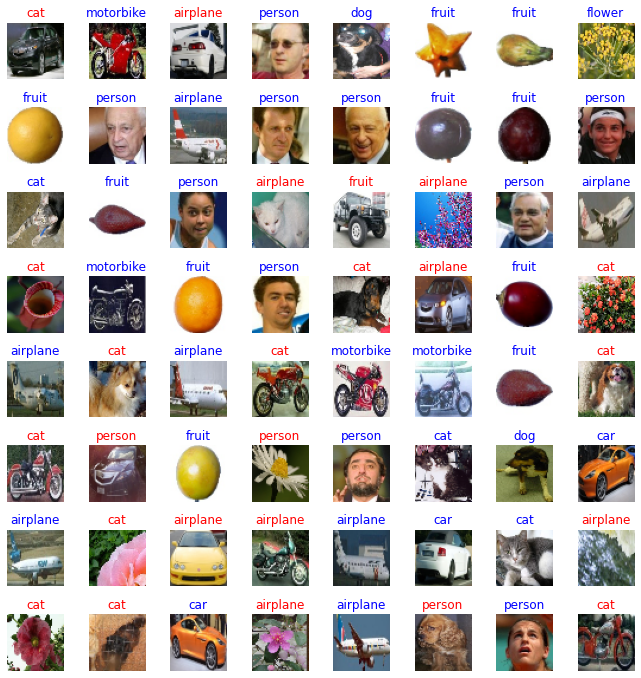

In [67]:
visualizar_predicoes(knn)   

## Classificador Random Forest
___

### Carregar ou treinar o modelo

In [68]:
rfc, grid_rf = carregar_modelo(RANDOM_FOREST)

if not rfc:
    start_time = time.time()
    print(f"Encontrando os melhores valores para os hiper parâmetros...")
    parameters = {
        'n_estimators': [50, 100],
        'min_samples_split': [2, 4],
        'max_depth' : [None, 4, 8],
        'criterion' :['gini', 'entropy']}
    rfc = RandomForestClassifier()
    grid_rf = GridSearchCV(rfc, parameters, cv=CV, scoring="accuracy", 
                        return_train_score=False, verbose=3, refit=True)

    grid_rf.fit(X_train, y_train)

    print(f"Melhor score médio: {grid_rf.best_score_}")
    print(f"Melhores parametros: {grid_rf.best_params_}")
   
    print(f"Salvando modelo Random Forest treinado com os melhores parâmetros encontrados.")
    rfc = grid_rf.best_estimator_

    salvar_modelo(RANDOM_FOREST, rfc, grid_rf)
    print(f"Treinamento finalizado em {time.time() - start_time} segundos.")
    
rfc    

Carregando o modelo rf: (rf_cv_2_img_size_48)
pronto!


RandomForestClassifier(criterion='entropy')

### Visualizar resultados do treinamento com GridSearchCV

In [69]:
visualizar_resultado_gridsearchcv(grid_rf)

Melhor acurácia média: 0.774235 com os parâmetros {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Acurácia média: 0.752854 desvio padrão: (0.001042) tempo médio de score: {0.126112) segs. Parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Acurácia média: 0.762095 desvio padrão: (0.004487) tempo médio de score: {0.228986) segs. Parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Acurácia média: 0.761371 desvio padrão: (0.005936) tempo médio de score: {0.132868) segs. Parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 50}
Acurácia média: 0.767893 desvio padrão: (0.003038) tempo médio de score: {0.173031) segs. Parâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}
Acurácia média: 0.600110 desvio padrão: (0.007356) tempo médio de score: {0.070657) segs. Parâmetros: {'criteri

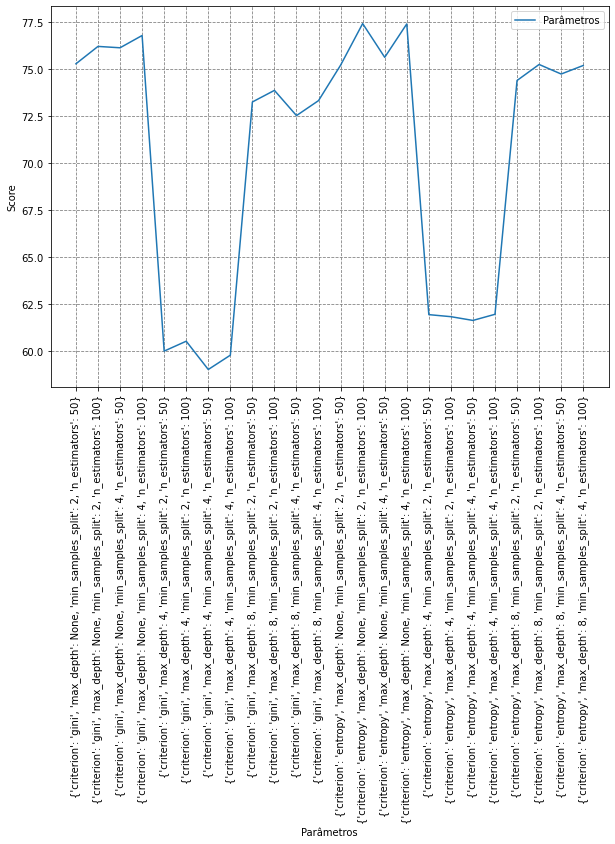

In [70]:
df_result = pd.DataFrame(grid_rf.cv_results_)[['params','mean_test_score']]
df_result['params'] = df_result['params'].astype(str)

visualizar_scores_parametros([{'x':df_result['params'],'y':df_result['mean_test_score']*100,'label':'Parâmetros'}],
                            "Score", "Parâmetros",90)

### Medir a acuracia do modelo

In [71]:
print(f"Acurácia do modelo nos dados de teste: {rfc.score(X_test, y_test)}")

Acurácia do modelo nos dados de teste: 0.7898550724637681


### Vizualizar a matriz confusão e o relatório de classificação

              precision    recall  f1-score   support

    airplane       0.86      0.87      0.87       145
         car       0.74      0.84      0.79       194
         cat       0.56      0.71      0.62       177
         dog       0.54      0.35      0.43       140
      flower       0.69      0.69      0.69       169
       fruit       1.00      1.00      1.00       200
   motorbike       0.88      0.77      0.82       158
      person       0.98      0.96      0.97       197

    accuracy                           0.79      1380
   macro avg       0.78      0.77      0.77      1380
weighted avg       0.79      0.79      0.79      1380



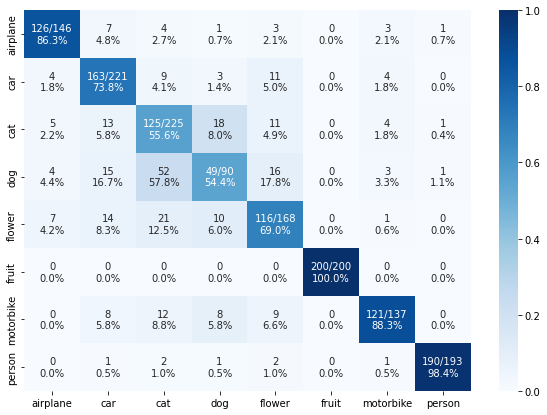

In [72]:
y_pred = rfc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

visualizar_matriz_confusao(cm, y_test, y_pred, True)

print(classification_report(y_test, y_pred, target_names=class_names))

df_class_report_rf = criar_classification_report_df(RANDOM_FOREST, y_test, y_pred)

 ### Visualizar predições

Acurácia: 75.00 (48 de 64)


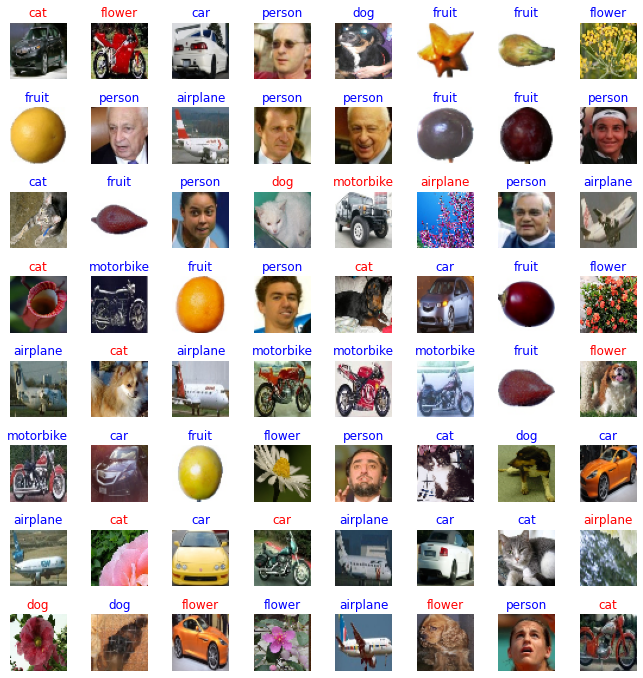

In [73]:
visualizar_predicoes(rfc)   

## Classificador SVM
___

### Carregar ou treinar o modelo

In [74]:
svm, grid_svm = carregar_modelo(SVM)

if not svm:
    start_time = time.time()
    print(f"Encontrando os melhores valores para os hiper parâmetros...")
    parameters = {'C': [0.1,1,10], 
                  'gamma': ['scale', 'auto'],
                  'kernel': ['linear','rbf', 'poly']}
        
    svm = SVC()
    grid_svm = GridSearchCV(svm, parameters, cv=CV, scoring='accuracy', 
                        return_train_score=False, verbose=3, refit=True)
    grid_svm.fit(X_train, y_train)

    print(f"Melhor score médio: {grid_svm.best_score_}")
    print(f"Melhores parametros: {grid_svm.best_params_}")
    
    print(f"Salvando modelo SVM treinado com os melhores parâmetros encontrados.")
    svm = grid_svm.best_estimator_

    salvar_modelo(SVM, svm, grid_svm)
    print(f"Treinamento finalizado em {time.time() - start_time} segundos.")    
    
svm    

Carregando o modelo svm: (svm_cv_2_img_size_48)
pronto!


SVC(C=10)

### Visualizar resultados do treinamento com GridSearchCV

In [75]:
visualizar_resultado_gridsearchcv(grid_svm)

Melhor acurácia média: 0.826056 com os parâmetros {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Acurácia média: 0.753035 desvio padrão: (0.001948) tempo médio de score: {25.011071) segs. Parâmetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Acurácia média: 0.688351 desvio padrão: (0.006466) tempo médio de score: {47.746067) segs. Parâmetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Acurácia média: 0.775505 desvio padrão: (0.011374) tempo médio de score: {23.106283) segs. Parâmetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Acurácia média: 0.753035 desvio padrão: (0.001948) tempo médio de score: {22.590316) segs. Parâmetros: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
Acurácia média: 0.475448 desvio padrão: (0.004262) tempo médio de score: {49.324934) segs. Parâmetros: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Acurácia média: 0.268526 desvio padrão: (0.003575) tempo médio de score: {37.225893) segs. Parâmetros: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Acurác

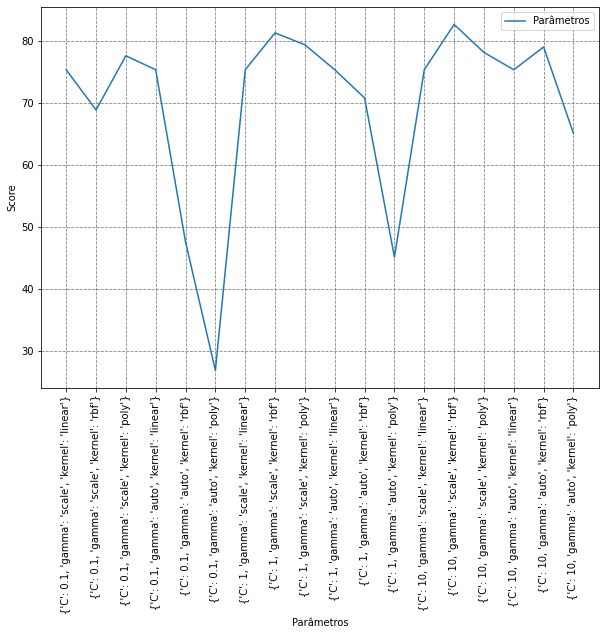

In [76]:
df_result = pd.DataFrame(grid_svm.cv_results_)[['params','mean_test_score']]
df_result['params'] = df_result['params'].astype(str)

visualizar_scores_parametros([{'x':df_result['params'],'y':df_result['mean_test_score']*100,'label':'Parâmetros'}],
                            "Score", "Parâmetros",90)

### Medir a acuracia do modelo

In [77]:
print(f"Acuracia do modelo nos dados de teste: {svm.score(X_test, y_test)}")

Acuracia do modelo nos dados de teste: 0.8536231884057971


### Visualizar a matriz confusão e o relatório de classificação

              precision    recall  f1-score   support

    airplane       0.93      0.92      0.93       145
         car       0.88      0.88      0.88       194
         cat       0.66      0.76      0.71       177
         dog       0.57      0.54      0.56       140
      flower       0.81      0.76      0.79       169
       fruit       0.99      1.00      0.99       200
   motorbike       0.95      0.89      0.92       158
      person       0.99      0.98      0.98       197

    accuracy                           0.85      1380
   macro avg       0.85      0.84      0.84      1380
weighted avg       0.86      0.85      0.85      1380



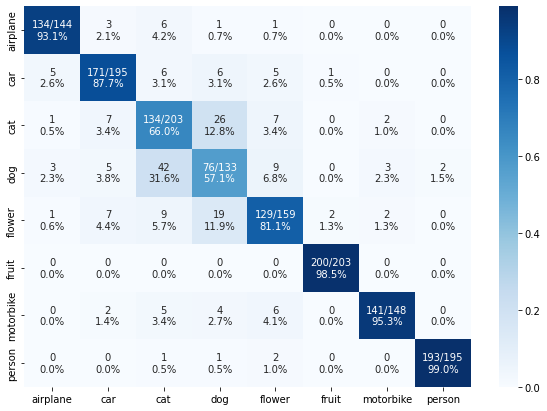

In [78]:
y_pred = svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

visualizar_matriz_confusao(cm, y_test, y_pred, True)

print(classification_report(y_test, y_pred, target_names=class_names))

df_class_report_svm = criar_classification_report_df(SVM, y_test, y_pred)

 ### Visualizar predições

Acurácia: 76.56 (49 de 64)


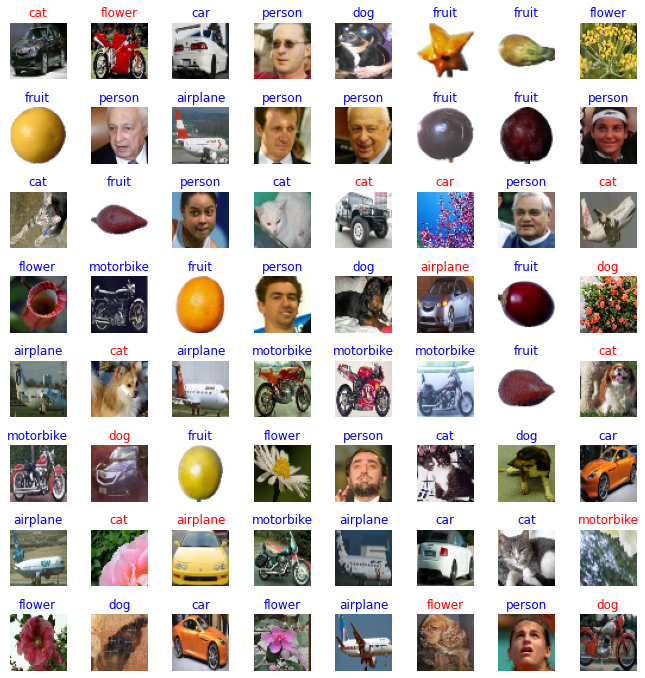

In [79]:
visualizar_predicoes(svm)   

## Classificador CNN
___

In [80]:
# essa funcao deve ser carregada mesmo quando o modelo nao esta sendo criado, pois a carga do grid search deve referencia-la
def create_model(optimizer='Adam', out_dim=128):
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    cnn.add(layers.MaxPooling2D((2, 2)))
    cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
    cnn.add(layers.MaxPooling2D((2, 2)))
    cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
    cnn.add(layers.MaxPooling2D((2, 2)))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(out_dim, activation='relu'))
    cnn.add(layers.Dense(len(class_names), activation='softmax'))

    cnn.compile(optimizer=optimizer,
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])

    return cnn

### Carregar ou treinar o modelo

In [81]:
history = History()
[cnn, history.history, grid_cnn] = carregar_modelo_cnn(CNN)

if not cnn:
    start_time = time.time()    

    print(f"Encontrando os melhores valores para os hiper parâmetros...")
    model = KerasClassifier(model=create_model, verbose=1, out_dim=128)
    parameters = {'optimizer': ['Adam', 'RMSprop','SGD'],
                  'out_dim': [128, 512],
                  'epochs': [30],
                  'batch_size':[32]}
    
    grid_cnn = GridSearchCV(model, param_grid=parameters, cv=CV, 
                        return_train_score=False, verbose=2, refit=True)

    grid_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn))

    print(f"Melhor score médio: {grid_cnn.best_score_}")
    print(f"Melhores parâmetros: {grid_cnn.best_params_}")

    print(f"Treinando modelo CNN em toda a base de treino com os melhores parâmetros encontrados.")
    cnn = create_model(grid_cnn.best_params_['optimizer'], grid_cnn.best_params_['out_dim'])

    history = cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn),
                      epochs=grid_cnn.best_params_['epochs'], 
                      batch_size=grid_cnn.best_params_['batch_size'])

    salvar_modelo_cnn(CNN, cnn, history, grid_cnn)
    print(f"Treinamento finalizado em {time.time() - start_time} segundos.")      
    
cnn.summary()

Carregando o modelo cnn: (cnn_cv_2_img_size_48)
pronto!
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 128)         73856     
                                                               

### Visualizar a acurácia e perda de treinamento e validação

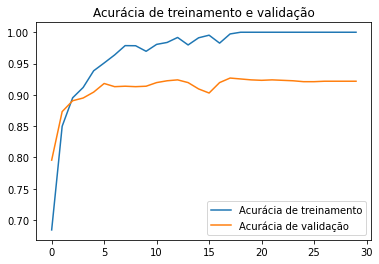

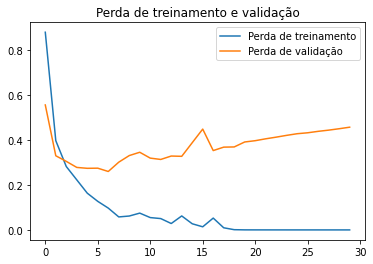

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '-', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, '-', label='Acurácia de validação')
plt.title('Acurácia de treinamento e validação')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-', label='Perda de treinamento')
plt.plot(epochs, val_loss, '-', label='Perda de validação')
plt.title('Perda de treinamento e validação')
plt.legend()

plt.show()

### Visualizar resultados do treinamento com GridSearchCV

In [83]:
visualizar_resultado_gridsearchcv(grid_cnn)

Melhor acurácia média: 0.911397 com os parâmetros {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adam', 'out_dim': 512}
Acurácia média: 0.901069 desvio padrão: (0.001105) tempo médio de score: {1.322712) segs. Parâmetros: {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adam', 'out_dim': 128}
Acurácia média: 0.911397 desvio padrão: (0.000165) tempo médio de score: {1.917076) segs. Parâmetros: {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adam', 'out_dim': 512}
Acurácia média: 0.901249 desvio padrão: (0.004185) tempo médio de score: {1.546255) segs. Parâmetros: {'batch_size': 32, 'epochs': 30, 'optimizer': 'RMSprop', 'out_dim': 128}
Acurácia média: 0.903242 desvio padrão: (0.006540) tempo médio de score: {1.978605) segs. Parâmetros: {'batch_size': 32, 'epochs': 30, 'optimizer': 'RMSprop', 'out_dim': 512}
Acurácia média: 0.902700 desvio padrão: (0.002338) tempo médio de score: {1.324393) segs. Parâmetros: {'batch_size': 32, 'epochs': 30, 'optimizer': 'SGD', 'out_dim': 128}
Acurácia média:

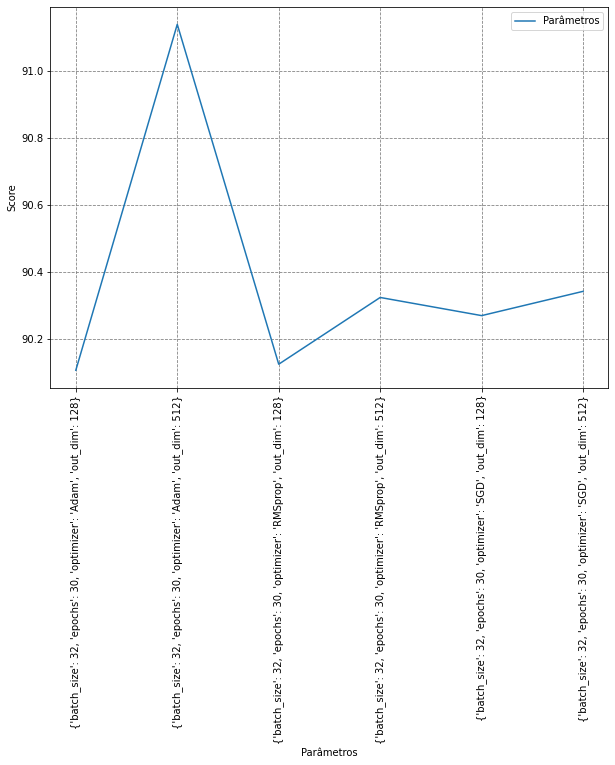

In [84]:
df_result = pd.DataFrame(grid_cnn.cv_results_)[['params','mean_test_score']]
df_result['params'] = df_result['params'].astype(str)

visualizar_scores_parametros([{'x':df_result['params'],'y':df_result['mean_test_score']*100,'label':'Parâmetros'}],
                            "Score", "Parâmetros",90)

### Medir a acuracia do modelo

In [85]:
test_score = cnn.evaluate(X_test_cnn, y_test_cnn, batch_size=grid_cnn.best_params_['batch_size'], verbose=1)

print("Acuracia do modelo nos dados de teste: {:.2f}%".format(test_score[1] * 100)) 
print("Perda: ",test_score[0])

44/44 [==============================] - 1s 18ms/step - loss: 0.4579 - accuracy: 0.9217
Acuracia do modelo nos dados de teste: 92.17%
Perda:  0.4578743278980255


### Visualizar a matriz confusão e o relatório de classificação

              precision    recall  f1-score   support

    airplane       0.96      0.96      0.96       145
         car       0.95      0.95      0.95       194
         cat       0.78      0.83      0.80       177
         dog       0.75      0.71      0.73       140
      flower       0.94      0.88      0.91       169
       fruit       0.99      1.00      0.99       200
   motorbike       0.97      0.98      0.98       158
      person       0.99      1.00      1.00       197

    accuracy                           0.92      1380
   macro avg       0.92      0.91      0.92      1380
weighted avg       0.92      0.92      0.92      1380



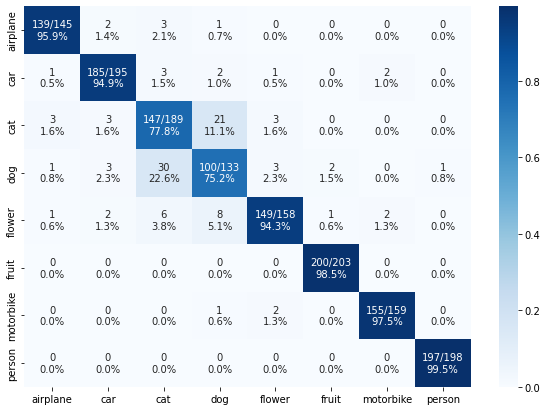

In [86]:
y_pred_prob = cnn.predict(X_test_cnn)

y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test_cnn, y_pred)

visualizar_matriz_confusao(cm, y_test_cnn, y_pred, True)

print(classification_report(y_test_cnn, y_pred, target_names=class_names, digits=2))

df_class_report_cnn = criar_classification_report_df(CNN, y_test_cnn, y_pred)

 ### Visualizar predições

Acurácia: 82.81 (53 de 64)


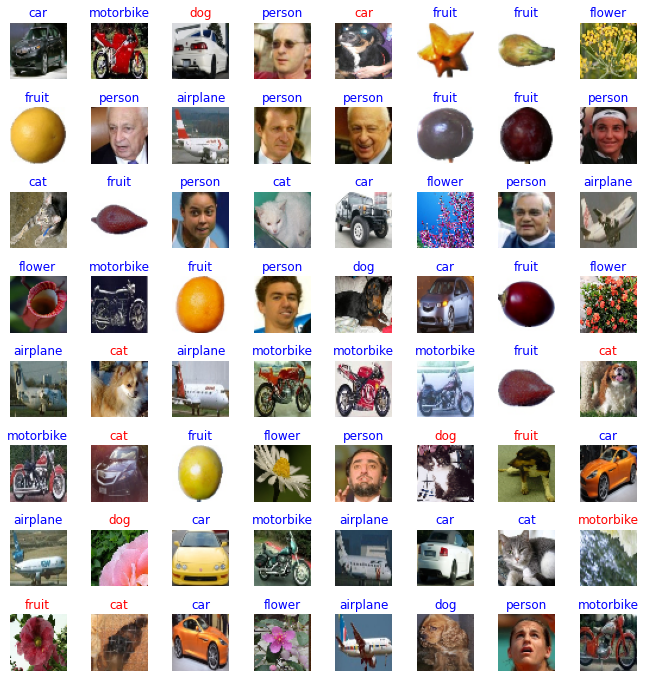

In [87]:
visualizar_predicoes(cnn)   

### Visualizar dados consolidados do classification_report

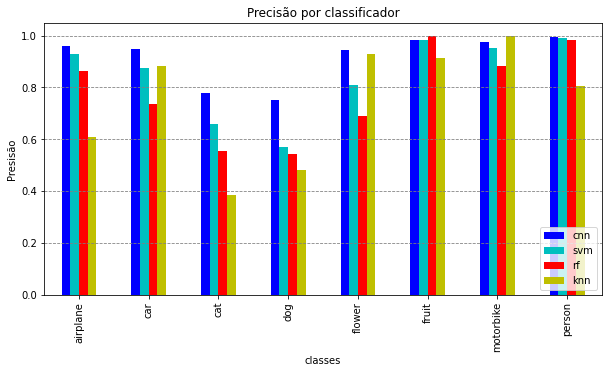

    precision    recall  f1-score   support classificador  variavel
8    0.693478  0.693478  0.693478  0.693478           knn  accuracy
19   0.789855  0.789855  0.789855  0.789855            rf  accuracy
30   0.853623  0.853623  0.853623  0.853623           svm  accuracy
41   0.921739  0.921739  0.921739  0.921739           cnn  accuracy


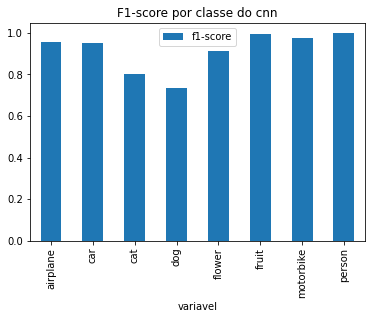

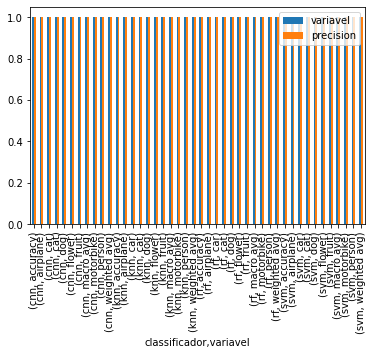

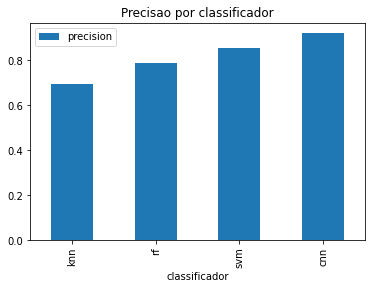

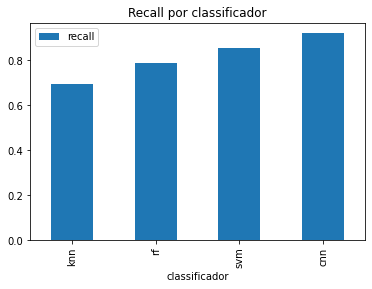

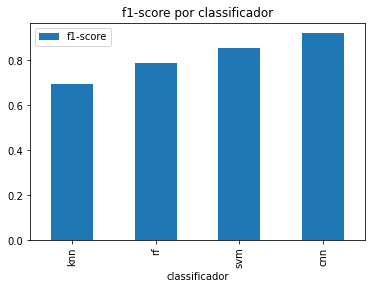

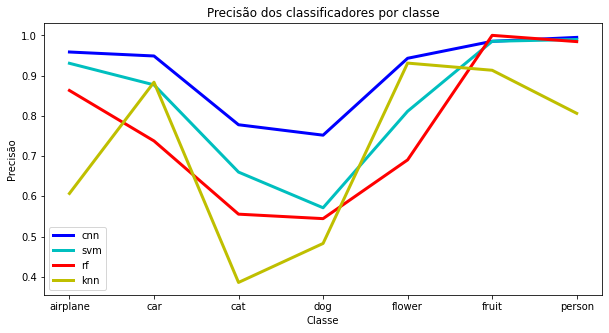

In [88]:
df_class_report = concatenar_classification_report_df([df_class_report_knn,df_class_report_rf,df_class_report_svm,df_class_report_cnn])

df1 = df_class_report.query("classificador == 'cnn' and variavel in ['airplane','car','cat','dog','flower','fruit','motorbike','person']")[['variavel','classificador','precision']].pivot(columns=['classificador'])
df1['cnn']=df1['precision']
df1.drop(['precision'], axis=1, inplace=True)
df1.reset_index(drop=True, inplace=True)

df2 = df_class_report.query("classificador == 'svm' and variavel in ['airplane','car','cat','dog','flower','fruit','motorbike','person']")[['variavel','classificador','precision']].pivot(columns=['classificador'])
df2['svm']=df2['precision']
df2.drop(['precision'], axis=1, inplace=True)
df2.reset_index(drop=True, inplace=True)

df3 = df_class_report.query("classificador == 'rf' and variavel in ['airplane','car','cat','dog','flower','fruit','motorbike','person']")[['variavel','classificador','precision']].pivot(columns=['classificador'])
df3['rf']=df3['precision']
df3.drop(['precision'], axis=1, inplace=True)
df3.reset_index(drop=True, inplace=True)

df4 = df_class_report.query("classificador == 'knn' and variavel in ['airplane','car','cat','dog','flower','fruit','motorbike','person']")[['variavel','classificador','precision']].pivot(columns=['classificador'])
df4['svm']=df4['precision']
df4.drop(['precision'], axis=1, inplace=True)
df4.reset_index(drop=True, inplace=True)

result = pd.concat([df1, df2, df3, df4], axis=1, sort=False, ignore_index=True)
result.drop(2, axis=1, inplace=True)
result.drop(4, axis=1, inplace=True)
result.drop(6, axis=1, inplace=True)
result.rename(columns={0:"classe", 1:"cnn", 3:"svm", 5:"rf", 7:"knn"}, inplace=True)


# precisao por classificador
ax = result.plot.bar(xlabel='classes',ylabel='Presisão',x='classe',figsize=(10,5), title="Precisão por classificador",color=['b', 'c', 'r', 'y'])
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.legend(loc='lower right')
plt.show()

# F1-score por classe do cnn
df_class_report.query("classificador == 'cnn' and variavel in ['airplane','car','cat','dog','flower','fruit','motorbike','person']").plot.bar(y='f1-score', x='variavel', title='F1-score por classe do cnn')
df_class_report.groupby(['classificador','variavel'])[['variavel','precision']].nunique().plot(kind='bar')

print(df_class_report.query("variavel in ['accuracy']"))
df_class_report.query("variavel in ['accuracy']").plot.bar(y='precision', x='classificador', title='Precisao por classificador')
df_class_report.query("variavel in ['accuracy']").plot.bar(y='recall', x='classificador', title='Recall por classificador')
df_class_report.query("variavel in ['accuracy']").plot.bar(y='f1-score', x='classificador', title='f1-score por classificador')

ax = df_class_report.query("classificador == 'cnn' and variavel in ['airplane','car','cat','dog','flower','fruit','motorboke','person']").plot(kind='line', y='precision', x='variavel', figsize=(10,5), color='b',linewidth=3)
df_class_report.query("classificador == 'svm' and variavel in ['airplane','car','cat','dog','flower','fruit','motorboke','person']").plot(kind='line', y='precision',x='variavel', figsize=(10,5), ax=ax, color='c',linewidth=3)
df_class_report.query("classificador == 'rf' and variavel in ['airplane','car','cat','dog','flower','fruit','motorboke','person']").plot(kind='line', y='precision',x='variavel', figsize=(10,5), ax=ax, color='r',linewidth=3)
df_class_report.query("classificador == 'knn' and variavel in ['airplane','car','cat','dog','flower','fruit','motorboke','person']").plot(kind='line', y='precision',ylabel='Precisão', x='variavel',xlabel='Classe',figsize=(10,5), title="Precisão dos classificadores por classe", ax=ax, color='y',linewidth=3)
ax.legend(["cnn", "svm","rf","knn"]);
plt.show()